In [1]:
# Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

In [2]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
# !pip install joblib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


# Read the CSV and Perform Basic Data Cleaning

In [4]:
# Read CSV
df = pd.read_csv("exoplanet_data.csv")

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Select your features (columns)

In [5]:
# Set features. This will also be used as your x values.
selected_features = df[['koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration',
                       'koi_depth', 'koi_prad', 'koi_steff', 'koi_slogg', 'koi_srad']]

# Note: Do not select the error margins

selected_features = selected_features.rename(columns = {
    'koi_disposition': "Planetary Status", 
    'koi_period': "Orbit period (d)", 
    'koi_time0bk': "Transit epoch", 
    'koi_duration': "Transit duration (h)",
    'koi_depth': "Transit depth", 
    "koi_prad": "Planet radius",
    'koi_steff': "Stellar temp (K)", 
    'koi_slogg': "Stellar gravity", 
    'koi_srad': "Stellar radius"
})

selected_features

,Planetary Status,Orbit period (d),Transit epoch,Transit duration (h),Transit depth,Planet radius,Stellar temp (K),Stellar gravity,Stellar radius
0,CONFIRMED,54.418383,162.513840,4.50700,874.8,2.83,5455,4.467,0.927
1,FALSE POSITIVE,19.899140,175.850252,1.78220,10829.0,14.60,5853,4.544,0.868
2,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,33.46,5805,4.564,0.791
3,CONFIRMED,2.525592,171.595550,1.65450,603.3,2.75,6031,4.438,1.046
4,CONFIRMED,4.134435,172.979370,3.14020,686.0,2.77,6046,4.486,0.972
...,...,...,...,...,...,...,...,...,...
6986,FALSE POSITIVE,8.589871,132.016100,4.80600,87.7,1.11,5638,4.296,1.088
6987,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,29.35,5638,4.529,0.903
6988,CANDIDATE,1.739849,133.001270,3.11400,48.5,0.72,6119,4.444,1.031
6989,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,1.07,6173,4.447,1.041


In [6]:
# Remove rows where "Planetary Status" is Candidate (unconfirmed status)
selected_features = selected_features.loc[selected_features["Planetary Status"] != "CANDIDATE"]

In [7]:
# Get count of Confirmed planets and False Positives
confirmed = selected_features.groupby("Planetary Status")
confirmed["Orbit period (d)"].count()

Planetary Status
CONFIRMED         1800
FALSE POSITIVE    3504
Name: Orbit period (d), dtype: int64

In [8]:
# Convert "Planetary Status" column to integer
selected_features = selected_features.replace({"CONFIRMED": int(1),
                                               "FALSE POSITIVE": int(-1)})

selected_features["Planetary Status"] = selected_features["Planetary Status"].astype("int64")

In [9]:
# Inspect planetary radius
print("max radius = ", selected_features["Planet radius"].max())
print("min radius = ", selected_features["Planet radius"].min())
print("median radius = ", selected_features["Planet radius"].median())

max radius =  200346.0
min radius =  0.14
median radius =  2.74


In [10]:
# Drop rows with extremely large planetary radii (improves scatter plot visualization and also model training)
selected_features = selected_features.loc[selected_features["Planet radius"] <=10000]

# Create a Train Test Split

Use `koi_disposition` for the y values

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [12]:
# Set y values (target). 
target = selected_features["Planetary Status"]
target_names = ["CONFIRMED", "FALSE POSITIVE"]

In [13]:
X = selected_features[["Orbit period (d)", "Transit epoch", "Transit duration (h)",
                            "Planet radius", "Stellar temp (K)", "Stellar gravity", "Stellar radius"]]

feature_names = X.columns

In [14]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=42)

# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [15]:
# Reshape the y values to pass through the MinMaxScaler() function
y_train.shape
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(3970, 1)
(1324, 1)


In [16]:
# Scale your data
X_minmax = MinMaxScaler(feature_range=(0, 10)).fit(X_train)
y_minmax = MinMaxScaler(feature_range=(0, 10)).fit(y_train)

X_train_scaled = X_minmax.transform(X_train)
X_test_scaled = X_minmax.transform(X_test)
y_train_scaled = y_minmax.transform(y_train)
y_test_scaled = y_minmax.transform(y_test)

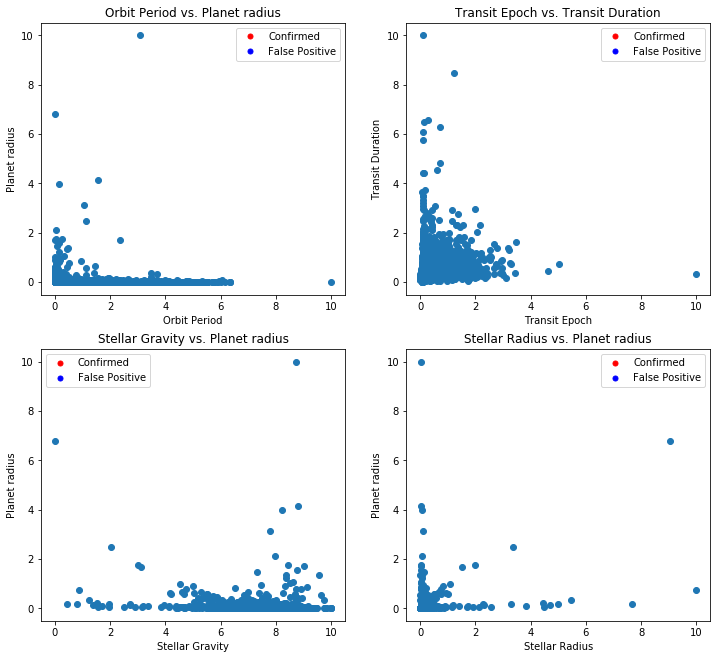

In [26]:
# Plot and show scatter plot data
fig1 = plt.figure(figsize=(12, 11))
axes1 = fig1.add_subplot(2, 2, 1)
axes2 = fig1.add_subplot(2, 2, 2)
axes3 = fig1.add_subplot(2, 2, 3)
axes4 = fig1.add_subplot(2, 2, 4)

def set_plot(axis, x_label, y_label, x_data, y_data):
    axis.set_title(f"{x_label} vs. {y_label}")
    axis.set_xlabel(f"{x_label}")
    axis.set_ylabel(f"{y_label}")
    red_dot = mlines.Line2D([], [], color="red", linestyle="None", marker=".", markersize=10, label="Confirmed")
    blue_dot = mlines.Line2D([], [], color="blue", linestyle="None", marker=".", markersize=10, label="False Positive")
    colors = ["red", "blue"]
    axis.legend(handles=[red_dot, blue_dot])
    return axis.scatter(x_data, y_data, cmap="bwr")

orbit_period = X_train_scaled[:, 0]
transit_epoch = X_train_scaled[:, 1]
transit_duration = X_train_scaled[:, 2]
planet_radius = X_train_scaled[:, 3]
stellar_gravity = X_train_scaled[:, 5]
stellar_radius = X_train_scaled[:, 6]

set_plot(axes1, "Orbit Period", "Planet radius", orbit_period, planet_radius);
set_plot(axes2, "Transit Epoch", "Transit Duration", transit_epoch, transit_duration);
set_plot(axes3, "Stellar Gravity", "Planet radius", stellar_gravity, planet_radius);
set_plot(axes4, "Stellar Radius", "Planet radius", stellar_radius, planet_radius);

plt.show()

# Train the Model



In [ ]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train_scaled)

In [ ]:
print(f"Training Data Score: {model.score(X_train_scaled, y_train_scaled)}")
print(f"Testing Data Score: {model.score(X_test_scaled, y_test_scaled)}")

In [ ]:
# Calculate classification report
from sklearn.metrics import classification_report
predictions = model.predict(X_test_scaled)
print(classification_report(y_test_scaled, predictions,
                            target_names=target_names))

# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [ ]:
# Create the GridSearchCV model
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC 
from sklearn import set_config
set_config(display="diagram")

pipe = make_pipeline(model)
pipe

In [ ]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(pipe, param_grid, verbose=3)

In [ ]:
# Train the model with GridSearch
# Fit the model using the grid search estimator. 
# This will take the SVC model and try each combination of parameters
# Note: This operation takes about 30-35 minutes to run.
grid.fit(X_train_scaled, y_train_scaled)

In [ ]:
# Print the best params
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test_scaled)

# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_scaled, predictions, target_names=target_names))

# Save the Model

In [ ]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'Robert_Ottogalli_SVM.sav'
joblib.dump(grid, filename)